# Flower Classification Training Notebook
Optimized CNN model for classifying flower images (rose, tulip, sunflower) with enhanced training pipeline.

## 1. Environment Setup

In [1]:
# Core imports
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML imports
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

# Verify TensorFlow and GPU
print(f"✅ TensorFlow {tf.__version__}")
gpu_available = len(tf.config.list_physical_devices('GPU')) > 0
print(f"✅ GPU available: {gpu_available}")

# Optimizations
if gpu_available:
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.config.optimizer.set_jit(True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-08-05 17:12:20.827741: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-05 17:12:20.835888: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-05 17:12:20.962687: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-05 17:12:22.983009: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


✅ TensorFlow 2.16.1
✅ GPU available: False


## 2. Configuration

In [2]:
# Training configuration
CONFIG = {
    'INPUT_SIZE': (160, 160),      # Increased from 128x128 for better feature extraction
    'BATCH_SIZE': 32,             
    'EPOCHS': 30,                  # Increased with early stopping
    'LEARNING_RATE': 0.001,        # More stable learning rate
    'VALIDATION_SPLIT': 0.2,
    'EARLY_STOPPING_PATIENCE': 5,  # More patience for convergence
    'REDUCE_LR_PATIENCE': 3,       
    'CLASS_NAMES': ['rose', 'tulip', 'sunflower'],
    'AUGMENTATION': True           # Explicit augmentation flag
}

# Directory setup
BASE_DIR = os.path.dirname(os.path.abspath('.'))
DATA_DIR = os.path.join(BASE_DIR, 'data')
MODELS_DIR = os.path.join(BASE_DIR, 'models')

# Create directories with proper path handling
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
for split in ['train', 'test', 'validation', 'uploads']:
    os.makedirs(os.path.join(DATA_DIR, split), exist_ok=True)
    for class_name in CONFIG['CLASS_NAMES']:
        os.makedirs(os.path.join(DATA_DIR, split, class_name), exist_ok=True)

print("⚙️ Configuration:")
for key, value in CONFIG.items():
    print(f"  {key:<25}: {value}")
print(f"\n📁 Data directory: {DATA_DIR}")
print(f"📁 Models directory: {MODELS_DIR}")

⚙️ Configuration:
  INPUT_SIZE               : (160, 160)
  BATCH_SIZE               : 32
  EPOCHS                   : 30
  LEARNING_RATE            : 0.001
  VALIDATION_SPLIT         : 0.2
  EARLY_STOPPING_PATIENCE  : 5
  REDUCE_LR_PATIENCE       : 3
  CLASS_NAMES              : ['rose', 'tulip', 'sunflower']
  AUGMENTATION             : True

📁 Data directory: /home/ngabotech/Desktop/Flower_classification/backend/data
📁 Models directory: /home/ngabotech/Desktop/Flower_classification/backend/models


## 3. Data Preparation

In [3]:
class DataPreprocessor:
    def __init__(self, data_dir, target_size):
        self.data_dir = data_dir
        self.target_size = target_size
        self.class_names = CONFIG['CLASS_NAMES']
        
    def get_dataset_statistics(self):
        stats = {'total_images': 0, 'class_distribution': {}}
        
        for split in ['train', 'test', 'validation']:
            split_count = 0
            for class_name in self.class_names:
                class_dir = os.path.join(self.data_dir, split, class_name)
                if os.path.exists(class_dir):
                    num_images = len([f for f in os.listdir(class_dir) 
                                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                    stats['class_distribution'].setdefault(class_name, {}).update({
                        split: num_images
                    })
                    split_count += num_images
            stats[f'{split}_images'] = split_count
            stats['total_images'] += split_count
            
        # Calculate dataset health metrics
        class_counts = [sum(v.values()) for v in stats['class_distribution'].values()]
        stats['balance_ratio'] = min(class_counts) / max(class_counts) if class_counts else 0
        stats['dataset_health'] = 'good' if stats['balance_ratio'] > 0.7 else 'imbalanced'
        
        return stats
    
    def create_data_generators(self, augmentation=True):
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=CONFIG['VALIDATION_SPLIT']
        ) if augmentation else tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
        
        test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
        
        train_generator = train_datagen.flow_from_directory(
            os.path.join(self.data_dir, 'train'),
            target_size=self.target_size,
            batch_size=CONFIG['BATCH_SIZE'],
            class_mode='categorical',
            subset='training'
        )
        
        val_generator = train_datagen.flow_from_directory(
            os.path.join(self.data_dir, 'train'),
            target_size=self.target_size,
            batch_size=CONFIG['BATCH_SIZE'],
            class_mode='categorical',
            subset='validation'
        )
        
        test_generator = test_datagen.flow_from_directory(
            os.path.join(self.data_dir, 'test'),
            target_size=self.target_size,
            batch_size=CONFIG['BATCH_SIZE'],
            class_mode='categorical',
            shuffle=False
        )
        
        return train_generator, val_generator, test_generator
    
    def get_class_weights(self):
        stats = self.get_dataset_statistics()
        class_counts = [sum(v.values()) for v in stats['class_distribution'].values()]
        total = sum(class_counts)
        return {i: total/(len(class_counts)*count) for i, count in enumerate(class_counts)}

In [4]:
# Initialize and check data
preprocessor = DataPreprocessor(DATA_DIR, CONFIG['INPUT_SIZE'])
stats = preprocessor.get_dataset_statistics()

print("📊 Dataset Statistics:")
print(f"  Total images: {stats['total_images']}")
print(f"  Training images: {stats['train_images']}")
print(f"  Validation images: {stats.get('validation_images', 0)}")
print(f"  Test images: {stats['test_images']}")
print(f"  Dataset health: {stats['dataset_health']} (balance ratio: {stats['balance_ratio']:.2f})")

if stats['total_images'] == 0:
    raise ValueError("No images found in dataset directories. Please add training data.")

# Create data generators
train_gen, val_gen, test_gen = preprocessor.create_data_generators(
    augmentation=CONFIG['AUGMENTATION']
)

print(f"\n✅ Data generators created with {len(train_gen.classes)} training samples")
print(f"   Class indices: {train_gen.class_indices}")
print(f"   Batch size: {CONFIG['BATCH_SIZE']}")
print(f"   Augmentation: {'ON' if CONFIG['AUGMENTATION'] else 'OFF'}")

📊 Dataset Statistics:
  Total images: 2786
  Training images: 2576
  Validation images: 0
  Test images: 210
  Dataset health: good (balance ratio: 0.77)
Found 2063 images belonging to 3 classes.
Found 514 images belonging to 3 classes.
Found 210 images belonging to 3 classes.

✅ Data generators created with 2063 training samples
   Class indices: {'rose': 0, 'sunflower': 1, 'tulip': 2}
   Batch size: 32
   Augmentation: ON


## 4. Model Creation

In [5]:
def create_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        # Feature extraction
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        # Classification head
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE']),
        loss='categorical_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    
    return model

# Initialize model
model = create_model(
    input_shape=(*CONFIG['INPUT_SIZE'], 3),
    num_classes=len(CONFIG['CLASS_NAMES'])
)

model.summary()

# Calculate model size
def get_model_size(model):
    model.save('temp_model.h5')
    size = os.path.getsize('temp_model.h5') / (1024 * 1024)
    os.remove('temp_model.h5')
    return size

print(f"\n📊 Model size: {get_model_size(model):.2f} MB")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 158, 158, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 77, 77, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 36, 36, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,939 (499.76 KB)

 Trainable params: 127,491 (498.01 KB)

 Non-trainable params: 448 (1.75 KB)


📊 Model size: 0.55 MB


## 5. Training

In [6]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=CONFIG['EARLY_STOPPING_PATIENCE'],
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=CONFIG['REDUCE_LR_PATIENCE'],
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        os.path.join(MODELS_DIR, 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Training
print("🚀 Starting training...")
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // CONFIG['BATCH_SIZE'],
    validation_data=val_gen,
    validation_steps=val_gen.samples // CONFIG['BATCH_SIZE'],
    epochs=CONFIG['EPOCHS'],
    callbacks=callbacks,
    class_weight=preprocessor.get_class_weights()
)

# Save final model
model.save(os.path.join(MODELS_DIR, 'final_model.keras'))
print("✅ Training completed and model saved")

🚀 Starting training...
Epoch 1/30


2025-08-05 17:12:31.494969: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102252544 exceeds 10% of free system memory.
2025-08-05 17:12:31.678168: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102252544 exceeds 10% of free system memory.
2025-08-05 17:12:31.880231: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102252544 exceeds 10% of free system memory.
2025-08-05 17:12:32.066840: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48570368 exceeds 10% of free system memory.
2025-08-05 17:12:32.253986: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48570368 exceeds 10% of free system memory.


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5338 - loss: 0.9676 - precision: 0.5730 - recall: 0.4634
Epoch 1: val_accuracy improved from None to 0.31641, saving model to /home/ngabotech/Desktop/Flower_classification/backend/models/best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.5835 - loss: 0.8840 - precision: 0.6179 - recall: 0.5263 - val_accuracy: 0.3164 - val_loss: 1.1525 - val_precision: 0.3208 - val_recall: 0.2832 - learning_rate: 0.0010
Epoch 2/30
 1/64 ━━━━━━━━━━━━━━━━━━━━ 5:06 5s/step - accuracy: 0.7188 - loss: 0.6543 - precision: 0.7586 - recall: 0.6875
Epoch 2: val_accuracy did not improve from 0.31641
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 390ms/step - accuracy: 0.7188 - loss: 0.6543 - precision: 0.7586 - recall: 0.6875 - val_accuracy: 0.3164 - val_loss: 1.1518 - val_precision: 0.3179 - val_recall: 0.2812 - learning_rate: 0.0010
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6500 - loss: 0.7552 - precision: 0.6734 - recall: 0.6040
Epoch

## 6. Evaluation

🧪 Evaluating model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 447ms/step - accuracy: 0.2857 - loss: 1.1471 - precision: 0.2984 - recall: 0.2714

📊 Test Results:
  Loss: 1.1471
  Accuracy: 0.2857
  Precision: 0.2984
  Recall: 0.2714
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 469ms/step

📋 Classification Report:
              precision    recall  f1-score   support

        rose       0.29      1.00      0.44        60
       tulip       0.00      0.00      0.00        75
   sunflower       0.00      0.00      0.00        75

    accuracy                           0.29       210
   macro avg       0.10      0.33      0.15       210
weighted avg       0.08      0.29      0.13       210



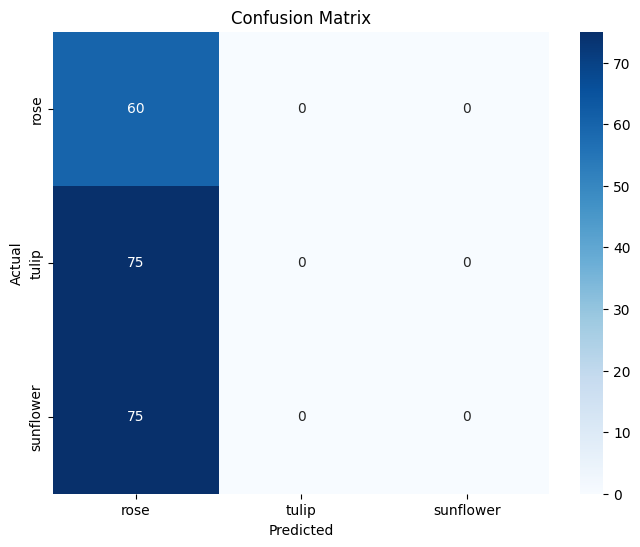

In [7]:
# Evaluate on test set
print("🧪 Evaluating model...")
test_results = model.evaluate(test_gen)
print(f"\n📊 Test Results:")
print(f"  Loss: {test_results[0]:.4f}")
print(f"  Accuracy: {test_results[1]:.4f}")
print(f"  Precision: {test_results[2]:.4f}")
print(f"  Recall: {test_results[3]:.4f}")

# Generate predictions
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Classification report
print("\n📋 Classification Report:")
print(classification_report(
    y_true, 
    y_pred_classes, 
    target_names=CONFIG['CLASS_NAMES']))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CONFIG['CLASS_NAMES'], 
            yticklabels=CONFIG['CLASS_NAMES'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 7. Model Deployment

In [8]:
# Save metadata
metadata = {
    'model_name': 'flower_classifier',
    'version': '1.0.0',
    'date_trained': datetime.now().isoformat(),
    'classes': CONFIG['CLASS_NAMES'],
    'class_indices': train_gen.class_indices,
    'input_shape': (*CONFIG['INPUT_SIZE'], 3),
    'training_metrics': {
        'final_accuracy': history.history['accuracy'][-1],
        'final_val_accuracy': history.history['val_accuracy'][-1],
        'test_accuracy': test_results[1]
    },
    'training_config': CONFIG
}

with open(os.path.join(MODELS_DIR, 'model_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ Deployment artifacts saved:")
print(f"  - Model: {os.path.join(MODELS_DIR, 'final_model.keras')}")
print(f"  - Metadata: {os.path.join(MODELS_DIR, 'model_metadata.json')}")

✅ Deployment artifacts saved:
  - Model: /home/ngabotech/Desktop/Flower_classification/backend/models/final_model.keras
  - Metadata: /home/ngabotech/Desktop/Flower_classification/backend/models/model_metadata.json
